In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

In [9]:
x_train = x_train.reshape(60000, 784)

In [10]:
x_train.shape

(60000, 784)

In [23]:
## Generator 모델 생성
np.random.seed(1000)
randomDim = 10
dLosses = []
gLosses = []
activation_g = tf.keras.layers.Activation(activation='tanh')

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, input_dim=randomDim),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(units=784, activation=activation_g)
])

In [15]:
## Discriminator 모델 생성
activation_d = tf.keras.layers.Activation(activation='sigmoid')

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1024, input_dim=784),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=1, activation=activation_d)
])

In [16]:
## Generator와 Discriminator 모델을 결합하여 GAN 모델 구성
## trainable 인수를 False로 설정하여 판별기의 가중치를 고정시킨다
discriminator.trainable = False
ganInput = tf.keras.layers.Input(shape=(randomDim,))
x = generator(ganInput)

ganOutput = discriminator(x)
gan = tf.keras.models.Model(inputs=ganInput, outputs=ganOutput)

In [17]:
## 판별기를 먼저 따로 훈련 시킨다
## binary_crossentropy를 손실 함수로 사용
discriminator.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam())
gan.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam())

In [25]:
## 훈련 시작
# 매 훈련 마다 랜덤 노이즈 샘플을 생성기에 공급하면 생성기는 가짜 이미지를 만든다
# 생성된 가짜 이미지와 실제 훈련 이미지를 특정 레이블과 함께 배치하고
# 이를 사용해 주어진 배치에서 먼저 판별기를 훈련시킨다
def train(epochs=1, batchSize=128):
    batchCount = int(x_train.shape[0] / batchSize)
    print(f'Epochs: {epochs}')
    print(f'Batch size: {batchSize}')
    print(f'Batches per epoch: {batchCount}')
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # 랜덤 입력 노이즈와 이미지를 얻는다
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = x_train[np.random.randint(0, x_train.shape[0], size=batchSize)]
            
            # 가짜 MNIST 이미지 생성
            generatedImages = generator.predict(noise)
            # np.shape(imageBatch)m np.shape(generatedImages) 출력
            X = np.concatenate([imageBatch, generatedImages])
            
            # 생성된 것과 실제 이미지의 레이블
            yDis = np.zeros(2 * batchSize)
            # 편파적 레이블 평활화
            yDis[:batchSize] = 0.9
            
            # 판별기 훈련
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
            # 생성기 훈련
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
        
        # 이 에폭의 최근 배치에서의 손실을 저장
        dLosses.append(dloss)
        gLosses.append(gloss)
        
        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)

In [26]:
# 각 배치에서 손실 도식화
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminative loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)
    
# 생성된 MNIST 이미지 나열
def saveGeneratedImages(epoch, examples=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

Epochs: 200
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
---------------

--------------- Epoch 198 ---------------
--------------- Epoch 199 ---------------
--------------- Epoch 200 ---------------


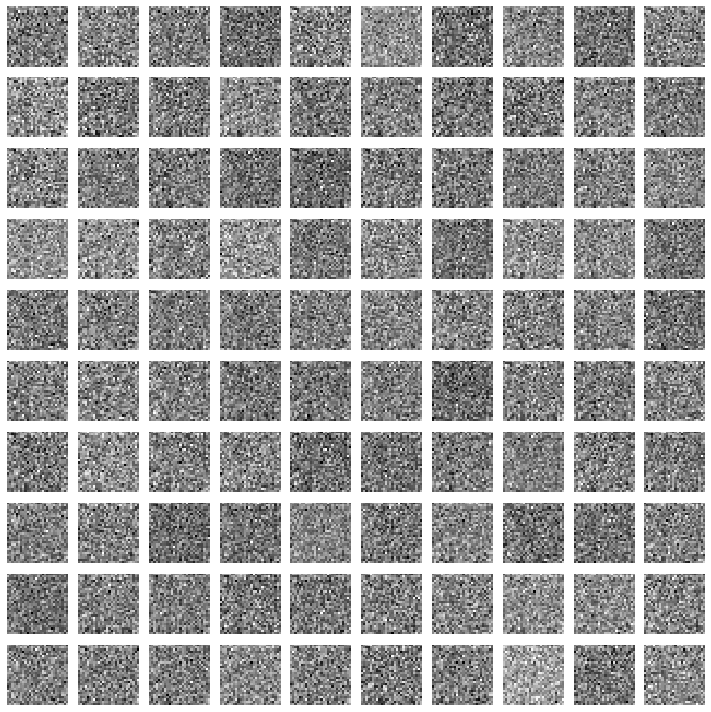

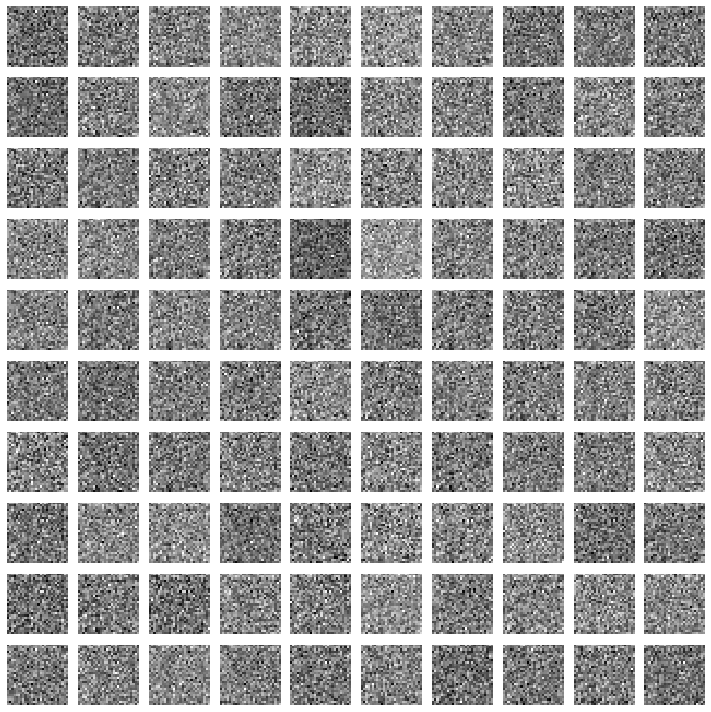

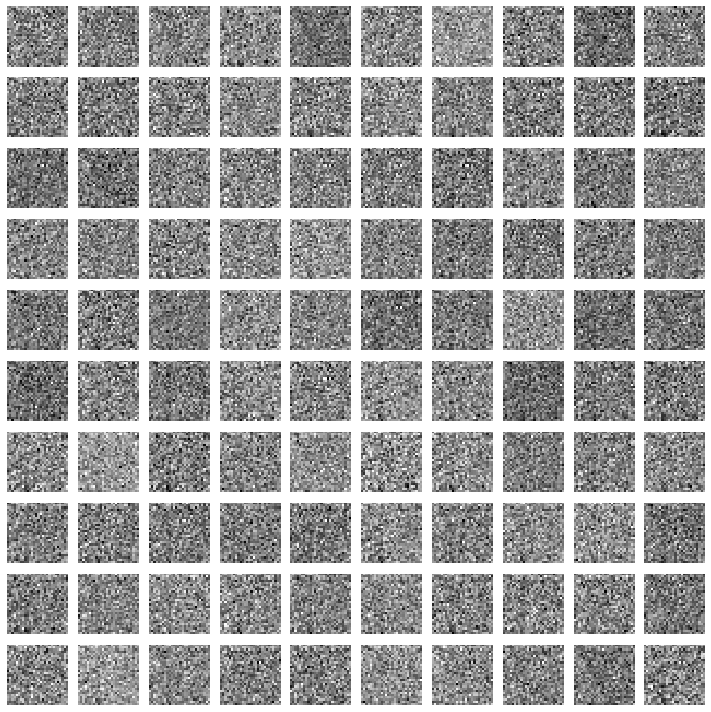

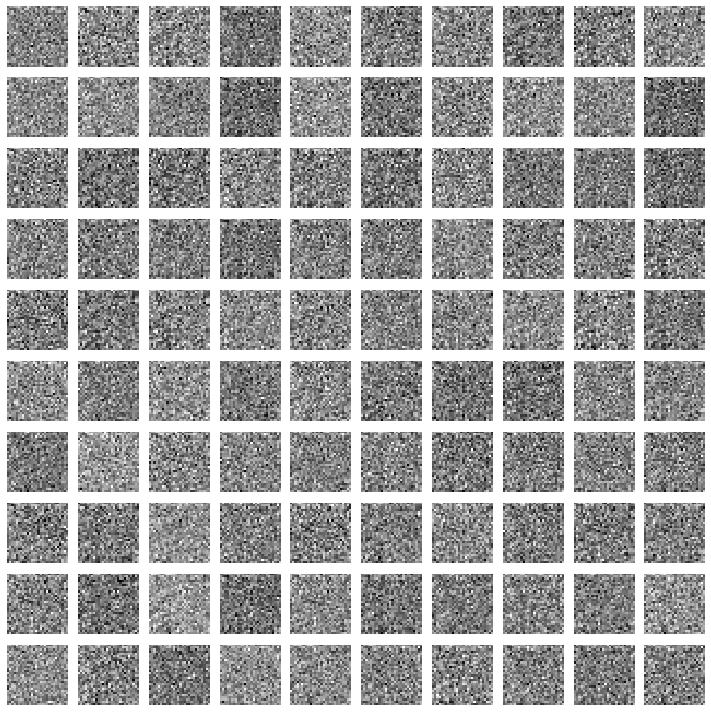

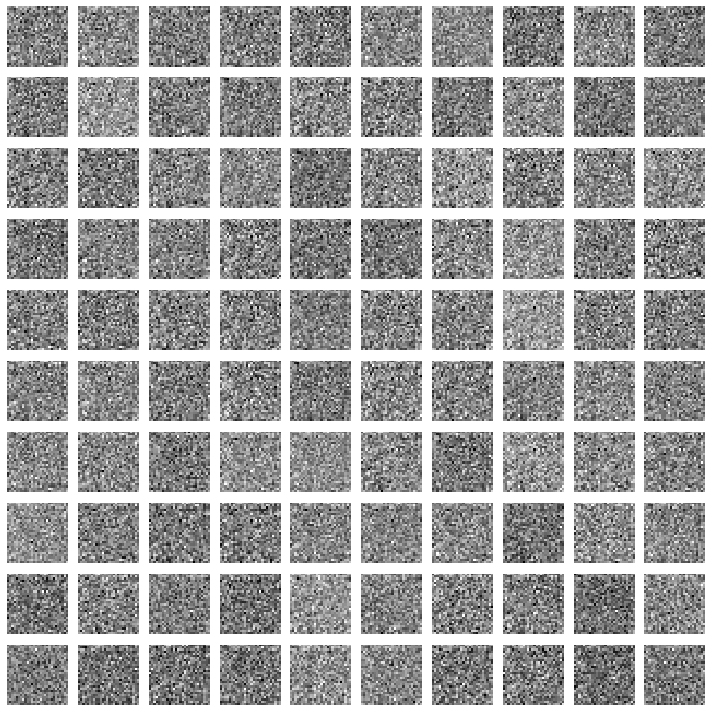

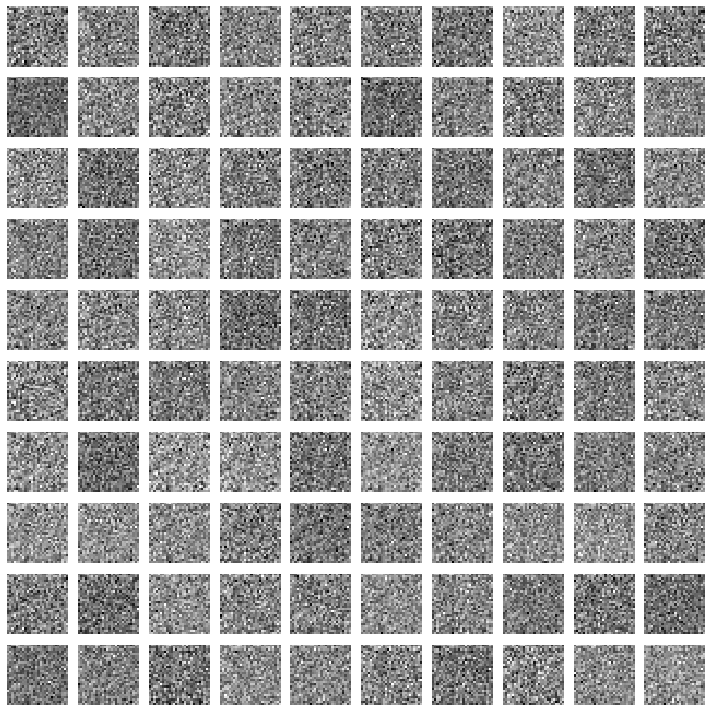

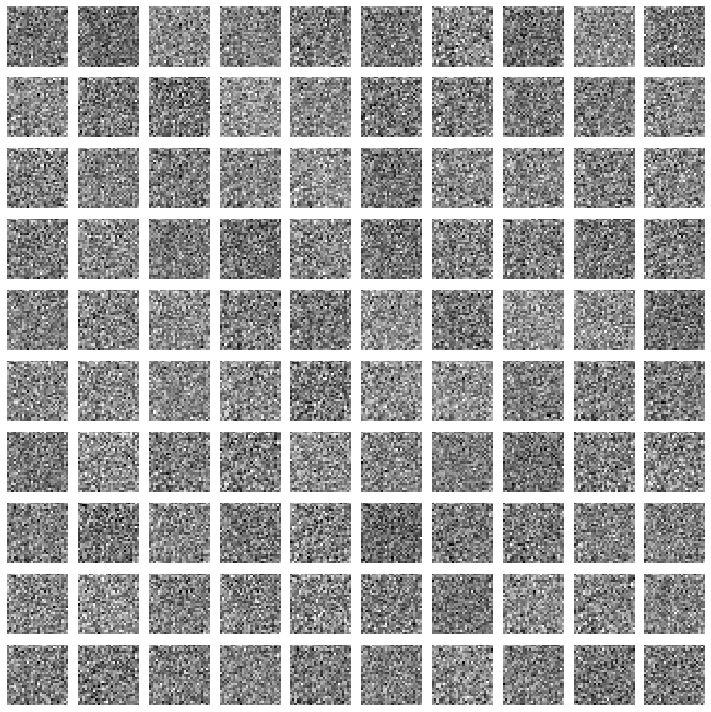

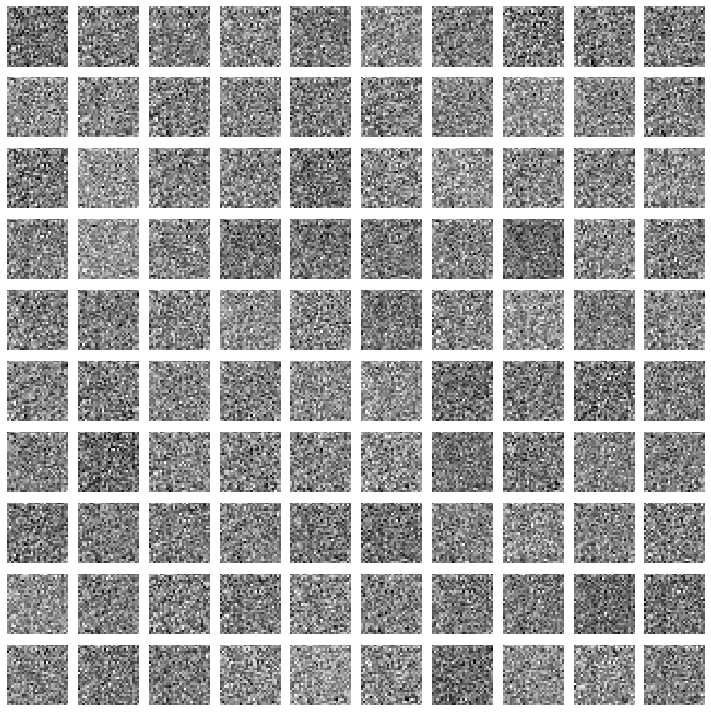

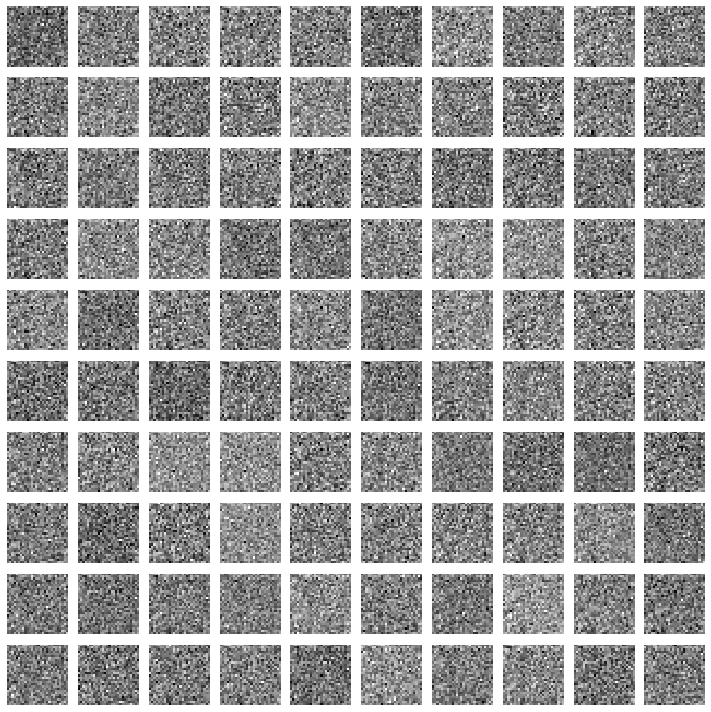

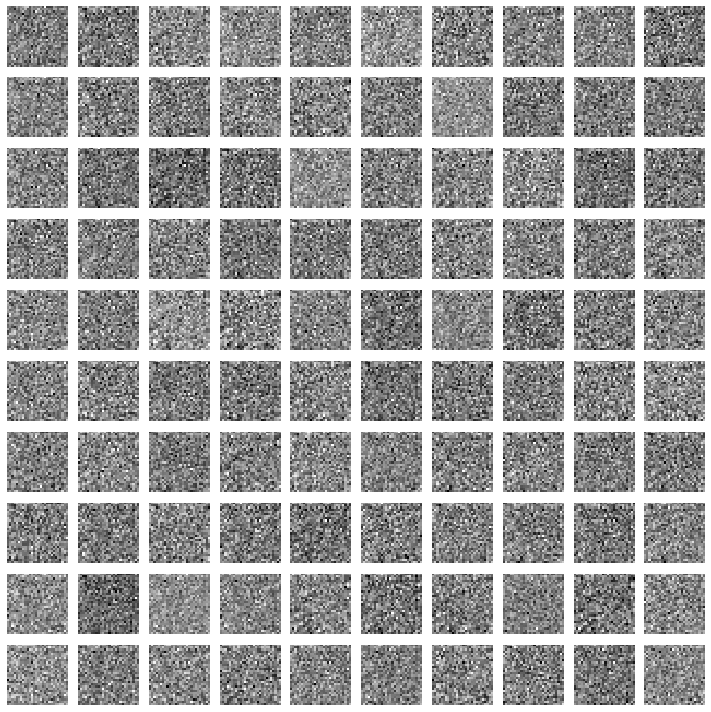

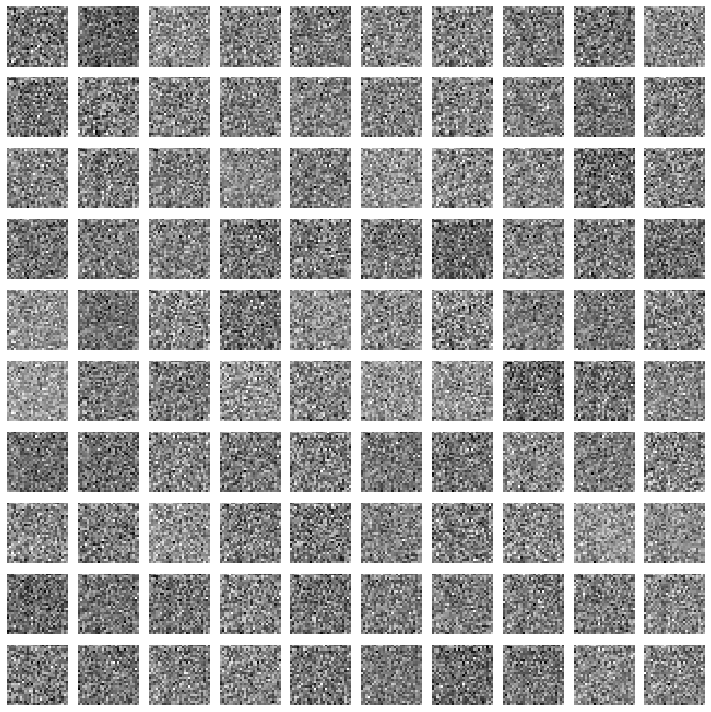

In [27]:
train(200, 128)